In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,root_mean_squared_error
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor

import time
from utils import dataset_summary


In [6]:
train = pd.read_csv('../data/X_train.csv')
test =  pd.read_csv('../data/X_test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')#This is a file with random numbers as predictions
                                                                #dans le futur fichier résultat ne pas mettre l'index

In [7]:
train.shape

(1285000, 14)

In [8]:
train.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,9.960940,1.491492,1.199018,-0.063145,0.595242,1.018416,1.248499,0.674080,-0.034194,-2.509908,-2.447517,-0.610936,-0.561048,255
256,10.000000,1.485476,1.222565,-0.250131,0.609230,1.048258,1.246830,0.859066,-0.050144,-2.533734,-2.469395,-0.608935,-0.559086,256
257,0.000000,1.000000,0.000000,0.000000,0.000000,-0.176502,0.555739,0.000000,0.000000,-0.823498,-0.555739,0.000000,0.000000,257
258,0.039062,0.999392,0.000131,-0.031160,0.006723,-0.176326,0.555148,0.008985,-0.030279,-0.823065,-0.555279,0.022176,0.023556,258


In [9]:
test.head(260)

,Id,t,x0_1,y0_1,x0_2,y0_2,x0_3,y0_3
0,0,0.000000,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085
1,1,0.039062,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085
2,2,0.078125,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085
3,3,0.117188,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085
4,4,0.156250,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085
...,...,...,...,...,...,...,...,...
255,255,9.960940,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085
256,256,10.000000,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085
257,257,0.000000,1.0,0.0,-0.061346,0.886386,-0.938654,-0.886386
258,258,0.039062,1.0,0.0,-0.061346,0.886386,-0.938654,-0.886386


REMOVAL OF TRAJECTORIES WITH ONLY ZEROS AND ZEROS AFTER COLLISION

In [10]:
def check_trajectories_start_zero(df, traj_len=257):
    num_traj = len(df) // traj_len
    zero_traj = []

    for i in range(num_traj):
        start_idx = i * traj_len
        first_row = df.iloc[start_idx]

        # Controlla se tutti i valori della prima riga sono zero
        if (first_row == 0).all():
            zero_traj.append(i)

    return zero_traj

In [11]:
train_no_id = train.iloc[:, :-1]
traj_zero=check_trajectories_start_zero(train_no_id,257)

# convert trajectory indices into row indices
row_indices = [i * 257 for i in traj_zero]

print("Trajectories starting with zeros:", traj_zero)
print("Corresponding starting rows:", row_indices)

Trajectories starting with zeros: [1050, 4058]
Corresponding starting rows: [269850, 1042906]


In [12]:
def remove_zero_trajectories(df, zero_traj, traj_len=257):
    drop_indices = []

    for traj_id in zero_traj:
        start = traj_id * traj_len
        end = (traj_id + 1) * traj_len
        drop_indices.extend(range(start, end))

    df_cleaned = df.drop(drop_indices).reset_index(drop=True)
    return df_cleaned

In [13]:
train_cleaned = remove_zero_trajectories(train, traj_zero, 257)

In [14]:
def remove_collision(df, traj_len=257, tol=1e-8):

    cleaned = []
    num_traj = len(df) // traj_len

    for i in range(num_traj):
        start = i * traj_len
        end = (i + 1) * traj_len
        traj = df.iloc[start:end]

        traj_features = traj.iloc[:, :-1]

        zero_mask = (np.abs(traj_features.values) < tol).all(axis=1)

        if zero_mask.any():
            first_zero = zero_mask.argmax() + start
            traj = traj.loc[start:first_zero-1]

        cleaned.append(traj)

    cleaned_df = pd.concat(cleaned).reset_index(drop=True)
    return cleaned_df

In [15]:
train_cleaned = remove_collision(train_cleaned)

CHECK ANOMALIES ON THE DATABASE TRAIN_CLEANED

In [16]:
def check_dataset_anomalies(df):
    print("Dataset anomalies check\n")

    # 1. Check for missing values (NaN)
    missing = df.isnull().sum().sum()
    if missing == 0:
        print("No missing values (NaN) found.")
    else:
        print(f"Found {missing} missing values (NaN).")
        print(df.isnull().sum()[df.isnull().sum() > 0])

    # 2. Check for infinite values
    inf_mask = df.isin([np.inf, -np.inf])
    inf_count = inf_mask.sum().sum()
    if inf_count == 0:
        print("No infinite values (+inf, -inf) found.")
    else:
        print(f"Found {inf_count} infinite values.")
        print(inf_mask.sum()[inf_mask.sum() > 0])

    # 3. Check for empty columns
    empty_cols = [col for col in df.columns if df[col].isnull().all()]
    if not empty_cols:
        print("No empty columns.")
    else:
        print(f"Found empty columns: {empty_cols}")


In [17]:
check_dataset_anomalies(train_cleaned)

Dataset anomalies check

No missing values (NaN) found.
No infinite values (+inf, -inf) found.
No empty columns.


In [18]:
train_cleaned.shape

(1089790, 14)

CHECK THE STATISTICS OF THE CLEANED DATASET

Shape: 1089790 rows, 13 columns

Basic statistics per column:
             min      mean        max
t       0.000000  4.887787  10.000000
x_1   -30.823004 -0.331674  16.340610
y_1   -17.857729 -0.129133  26.276226
v_x_1 -72.993333 -0.217109  23.503455
v_y_1 -23.109278 -0.019456  34.671679
x_2   -30.833398  0.008456  15.506957
y_2   -52.450808 -0.096702  35.679463
v_x_2 -25.895550  0.038295  72.718229
v_y_2 -48.289007 -0.098585  23.118346
x_3   -17.439994  0.323218  61.656402
y_3   -33.159997  0.225835  27.735539
v_x_3 -30.970540  0.178814  25.964992
v_y_3 -25.509384  0.118041  48.288738

Standard deviation:
t        2.918751
x_1      1.836845
y_1      1.266963
v_x_1    0.949104
v_y_1    0.875636
x_2      1.154264
y_2      1.127168
v_x_2    1.016519
v_y_2    1.058225
x_3      1.562294
y_3      1.825727
v_x_3    0.852717
v_y_3    0.944614
Name: std, dtype: float64


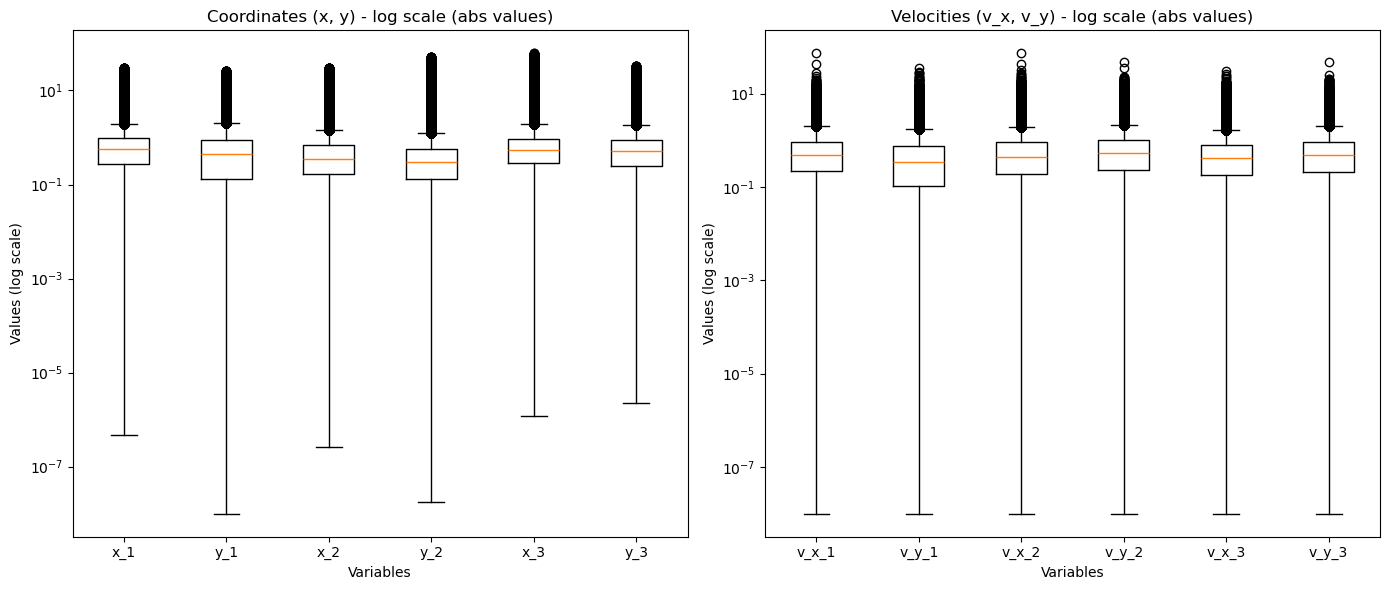

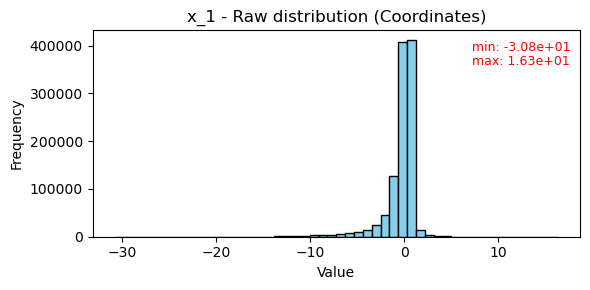

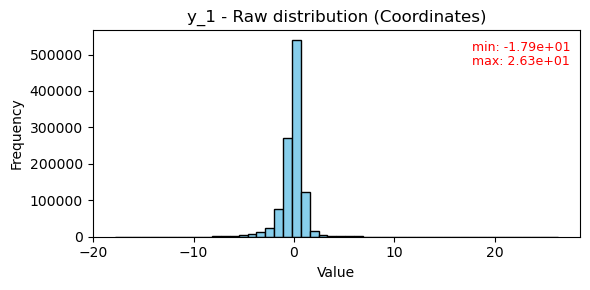

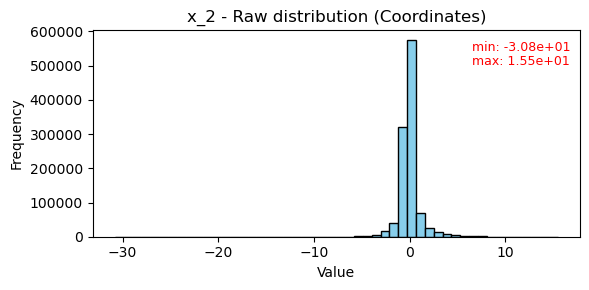

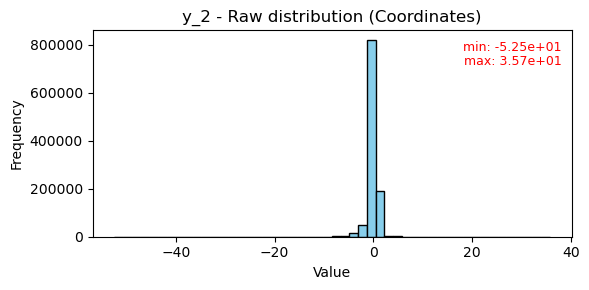

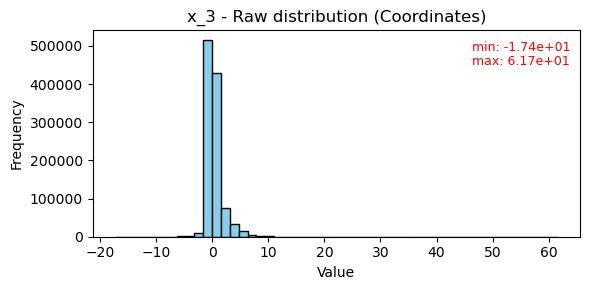

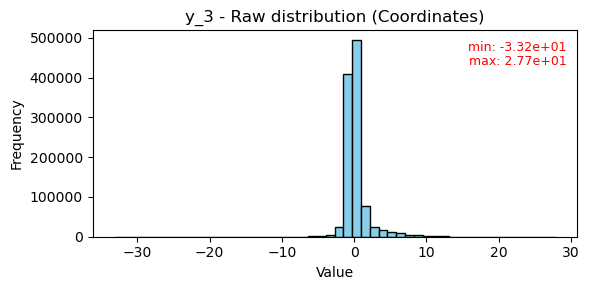

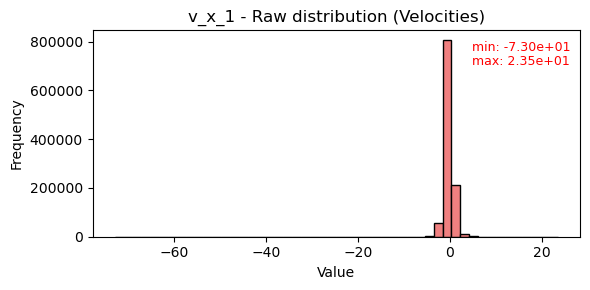

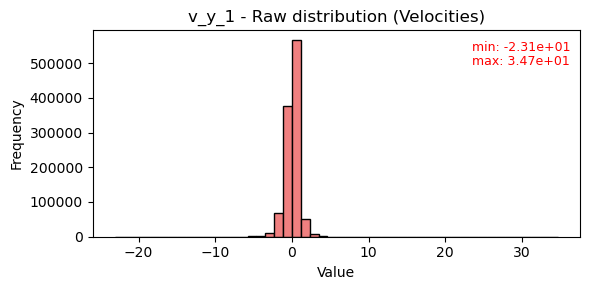

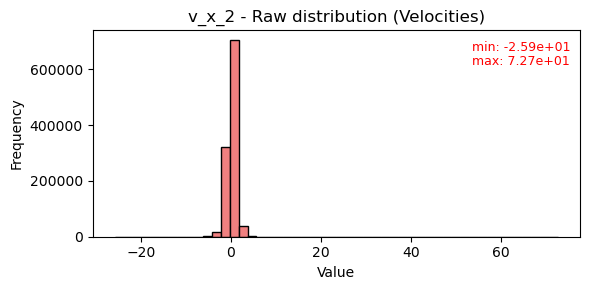

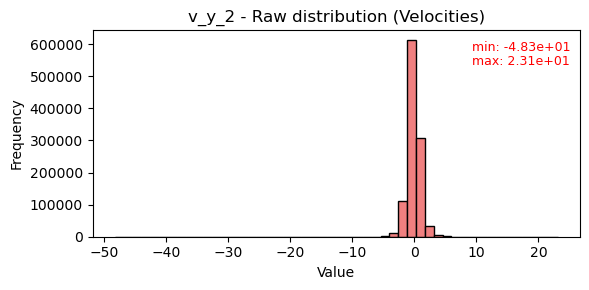

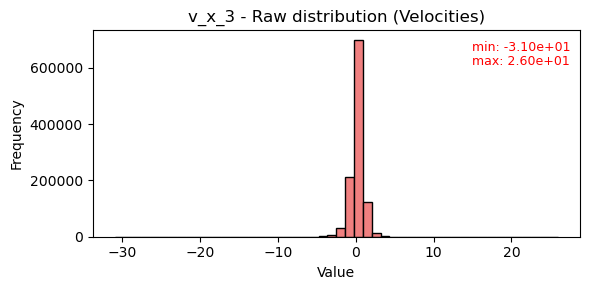

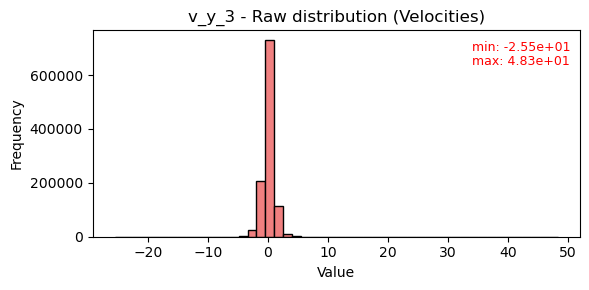

In [19]:
train_cleaned_no_id = train_cleaned.iloc[:, :-1]
dataset_summary(train_cleaned_no_id)